In [2]:
import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter

In [188]:
def Radon_forward(n,u):
    """
    Matrix-free matvec with Radon
    """
    # volume grid
    h = 2/n
    x = -1 + np.linspace(0,n,n+1)*h
    
    # detector grid
    m = int(3/h)+1
    s = np.linspace(-1.5,1.5,m)
    
    # angular grid
    theta = np.linspace(0,2*np.pi,n)
    
    #
    ss,xx = np.meshgrid(s,x)
    
    # 
    f = np.zeros((n,m))
    for i in range(n):
        # compute all intersections with horizontal and vertical grid lines
        # in terms of path length parameter t
        tt = np.zeros((0,m))
        if np.abs(np.sin(theta[i])) > 0:
            tx = (xx - ss*np.cos(theta[i]))/np.sin(theta[i])
            tt = np.concatenate((tt,tx))
        if np.abs(np.cos(theta[i])) > 0 :
            ty = -(xx - ss*np.sin(theta[i]))/np.cos(theta[i])
            tt = np.concatenate((tt,ty))

        # sort t in increasing order
        tt = np.sort(tt,axis=0)

        # intersection points
        xi =  tt*np.sin(theta[i]) + s*np.cos(theta[i])
        yi = -tt*np.cos(theta[i]) + s*np.sin(theta[i])

        Ix = (((xi[:-1,:] + xi[1:,:])/2+1)//h).astype(int).T
        Iy = (((yi[:-1,:] + yi[1:,:])/2+1)//h).astype(int).T
        W = (tt[1:,:] - tt[:-1,:]).T

        index = np.logical_and(np.logical_and(0<=Ix, Ix<n),np.logical_and(0<=Iy, Iy<n))

        Ix = np.where(index,Ix,0)
        Iy = np.where(index,Iy,0)
        W = np.where(index,W,0)
        for j in range(m):
            f[i,j] = u[Ix[j],Iy[j]].dot(W[j])
    return f

In [189]:
def Radon_adjoint(n,f):
    """
    Matrix-free matvec with Radon
    """
    # volume grid
    h = 2/n
    x = -1 + np.linspace(0,n,n+1)*h
    
    # detector grid
    m = int(3/h)+1
    s = np.linspace(-1.5,1.5,m)
    
    # angular grid
    theta = np.linspace(0,2*np.pi,n)
    
    #
    ss,xx = np.meshgrid(s,x)
    
    # 
    u = np.zeros(n*n)
    
    for i in range(n):
        # compute all intersections with horizontal and vertical grid lines
        # in terms of path length parameter t
        tt = np.zeros((0,m))
        if np.abs(np.sin(theta[i])) > 0:
            tx = (xx - ss*np.cos(theta[i]))/np.sin(theta[i])
            tt = np.concatenate((tt,tx))
        if np.abs(np.cos(theta[i])) > 0 :
            ty = -(xx - ss*np.sin(theta[i]))/np.cos(theta[i])
            tt = np.concatenate((tt,ty))

        # sort t in increasing order
        tt = np.sort(tt,axis=0)

        # intersection points
        xi =  tt*np.sin(theta[i]) + s*np.cos(theta[i])
        yi = -tt*np.cos(theta[i]) + s*np.sin(theta[i])

        Ix = (((xi[:-1,:] + xi[1:,:])/2+1)//h).astype(int).T
        Iy = (((yi[:-1,:] + yi[1:,:])/2+1)//h).astype(int).T
        W = (tt[1:,:] - tt[:-1,:]).T

        index = np.logical_and(np.logical_and(0<=Ix, Ix<n),np.logical_and(0<=Iy, Iy<n))

        Ix = np.where(index,Ix,0)
        Iy = np.where(index,Iy,0)
        W = np.where(index,W,0)
        for j in range(m):
            u[Ix[j]*n + Iy[j]] += W[j]*f[i,j]
    return u.reshape(n,n)

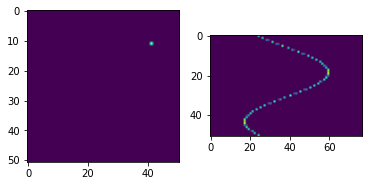

In [190]:
# sanity check

# paramters
n = 51

u = np.zeros((n,n))
u[11,41] = 1
f = Radon_forward(n,u)
fig,ax = plt.subplots(1,2)
ax[0].imshow(u)
ax[1].imshow(f)

In [214]:
# adjoint test
n = 101
u1 = np.random.randn(n,n)
f1 = Radon_forward(n,u1)
u2 = Radon_adjoint(n,f1)

print(np.sum(u1*u2)/np.sum(f1*f1))

0.9995837318390539


In [210]:
# timing (expect O(N^3))
N = np.array([8, 16,32,64,128,256])
Tf = np.zeros(len(N))
Tb = np.zeros(len(N))
for i in range(len(N)):
    n = N[i]
    u1 = np.random.randn(n,n)
    
    t0 = perf_counter()
    f1 = Radon_forward(n,u1)
    t1 = perf_counter()
    Tf[i] = t1-t0
    
    t0 = perf_counter()
    f1 = Radon_adjoint(n,f1)
    t1 = perf_counter()
    Tb[i] = t1-t0
    
    print(N[i],Tf[i],Tb[i])

8 0.007120132999261841 0.004496009998547379
16 0.010368179002398392 0.006496297999547096
32 0.016823579000629252 0.018915922999440227
64 0.08131580500048585 0.1000526819989318
128 0.5664787599998817 0.6072545839997474
256 4.180108434000431 4.769664794999699


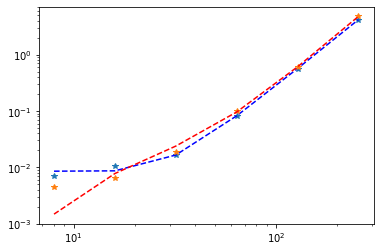

In [212]:
B = np.array([0*N+1,N,N**2,N**3]).T
cf = np.linalg.pinv(B)@Tf
cb = np.linalg.pinv(B)@Tb

plt.loglog(N,Tf,'*',N,B@cf,'b--')
plt.loglog(N,Tb,'*',N,B@cb,'r--')